In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import numpy as np

### Loading the Data using torchvision

In [2]:
#Loading the image file and label mapping data
image_mapping_data = pd.read_csv(r"D:\Capstone\Data\ImageLabelMapping.csv")
image_mapping_data.head()

,filename,Label
0,L427F01330C01S03961Rp02052.jpg,0
1,L1083F00930C39S12674Ip.jpg,0
2,24_initial_1_1463_1463.JPG,0
3,L341F00167C01S00324Rp14178.jpg,1
4,L1084F02394C39S13931Ip.jpg,0


In [3]:
#splitting the data into training and validation sets with stratification  
from sklearn.model_selection import train_test_split

X = image_mapping_data['filename']
y = image_mapping_data['Label']
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size = 0.2, stratify=y)

In [4]:
#verifying if the stratification worked
from collections import Counter

print(Counter(y_train))
print(Counter(y_val))

Counter({0: 17241, 1: 3613})
Counter({0: 4311, 1: 903})


In [5]:
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

### Image Dataset Loader

In [6]:
#creating the custom Dataset class in pytorch.
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import cv2

RESCALE = 128

class ImageDataset(Dataset):
    def __init__(self, img_dir, img_files, img_labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_files = img_files
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (RESCALE, RESCALE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
from torchvision import transforms
train_transform = transforms.Compose([transforms.ToTensor()])
val_transform = transforms.Compose([transforms.ToTensor()])

In [8]:
img_dir = "D:\Capstone\Data\data_train"
train_set = ImageDataset(img_dir, X_train, y_train, transform = train_transform)
val_set = ImageDataset(img_dir, X_val, y_val, transform = val_transform)

print("Training data size",train_set.__len__())
print("Validation data size",val_set.__len__())

Training data size 20854
Validation data size 5214


In [9]:
BATCH_SIZE = 10

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


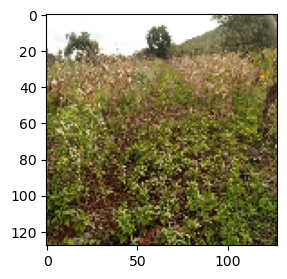

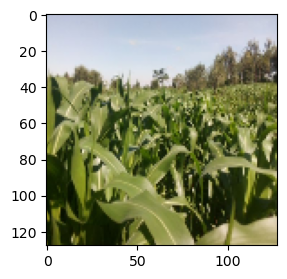

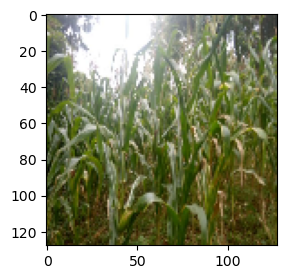

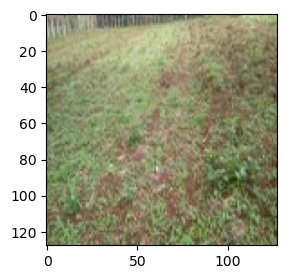

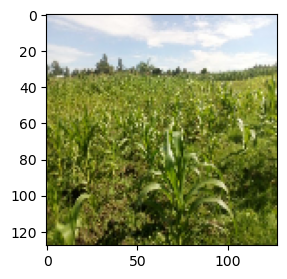

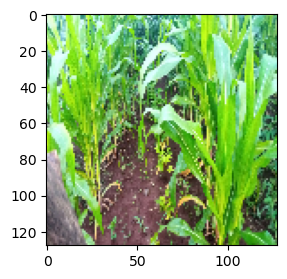

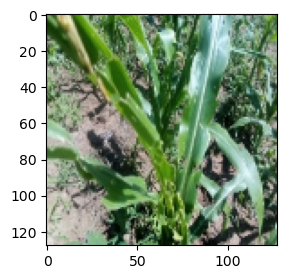

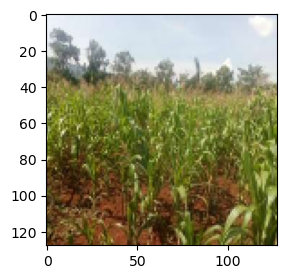

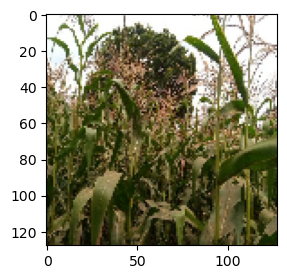

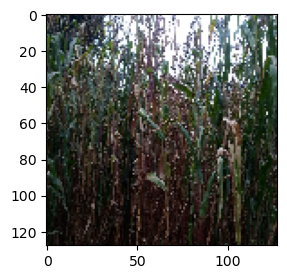

In [10]:
img, label = next(iter(train_loader))

# 0-NonDR, 1-DR 
print(label)

for i in img:
    plt.figure(figsize=(3,3))
    npimg = np.array(i)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [11]:
print(torch.min(img), torch.max(img))

tensor(0.) tensor(1.)


### Building the model

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Loop

In [12]:
def train_one_epoch(epoch_index, tb_writer, model, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Custom Auto-encoders

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [16]:
custom_autoen = Autoencoder()
custom_autoen.to(device)
summary(custom_autoen,(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 30, 30]          51,264
              ReLU-8           [-1, 64, 30, 30]               0
         MaxPool2d-9           [-1, 64, 15, 15]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          51,232
             ReLU-11           [-1, 32, 32, 32]               0
  ConvTranspose2d-12           [-1, 16, 64, 64]           4,624
             ReLU-13           [-1, 16, 64, 64]               0
  ConvTranspose2d-14          [-1, 3, 1

In [60]:
loss_fn_autoen = nn.MSELoss()
optimizer_autoen = optim.Adam(custom_autoen.parameters(), lr=0.001)

In [61]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

writer_autoen = SummaryWriter(r"D:\Capstone\runs\img_classifier_autoen{}".format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

In [62]:
%%time

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    custom_autoen.train(True)
    avg_loss = train_one_epoch(epoch_number, writer_autoen, custom_autoen, optimizer_autoen, loss_fn_autoen)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    custom_autoen.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vlabels = vlabels.to(torch.float32)
            voutputs = custom_autoen(vinputs)
            vloss = loss_fn_autoen(voutputs, vinputs)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer_autoen.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer_autoen.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(custom_autoen.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.018618025626055898
  batch 2000 loss: 0.013574284536764026
LOSS train 0.013574284536764026 valid 0.012785961851477623
EPOCH 2:
  batch 1000 loss: 0.012539271367713808
  batch 2000 loss: 0.012126157913357019
LOSS train 0.012126157913357019 valid 0.011824511922895908
EPOCH 3:
  batch 1000 loss: 0.01156732258782722
  batch 2000 loss: 0.011518525878433139
LOSS train 0.011518525878433139 valid 0.01119089312851429
EPOCH 4:
  batch 1000 loss: 0.011082345629576594
  batch 2000 loss: 0.011026039385935292
LOSS train 0.011026039385935292 valid 0.010880001820623875
EPOCH 5:
  batch 1000 loss: 0.010813224076293409
  batch 2000 loss: 0.010634752789512276
LOSS train 0.010634752789512276 valid 0.010649197734892368
EPOCH 6:
  batch 1000 loss: 0.010626483247149736
  batch 2000 loss: 0.010407799749402329
LOSS train 0.010407799749402329 valid 0.010453011840581894
EPOCH 7:
  batch 1000 loss: 0.010390128215542064
  batch 2000 loss: 0.010315157889854163
LOSS train 0.010315157889

In [57]:
best_autoen = Autoencoder()
best_autoen.load_state_dict(torch.load(r"D:\Capstone\Data\model_20231031_164704_9"))
best_autoen.eval()
#best_autoen.to(device)
best_autoen

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

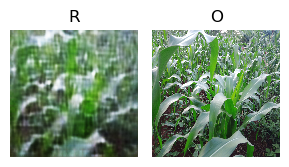

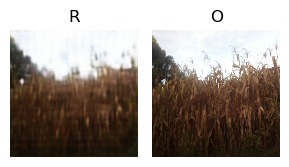

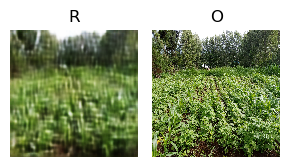

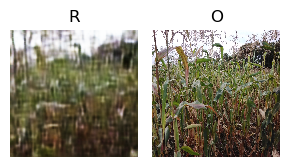

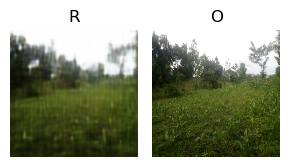

In [64]:
from matplotlib import transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

outputs = {} 

img, _ = next(iter(val_loader))
#img = img.to(device)
out = best_autoen(img) 

outputs['img'] = img 
outputs['out'] = out 
  
# Plotting reconstructed images 
# Initializing subplot counter 
counter = 1
val_out = outputs['out'].detach().numpy()
val_img = outputs['img']


# Plotting first 10 images of the batch 
for idx in range(5):
    plt.figure(figsize=(3, 3)) 
    plt.subplot(1, 2, 1) 
    plt.title("R") 
    plt.imshow(np.transpose(val_out[idx], (1, 2, 0))) 
    plt.axis('off') 
    plt.subplot(1, 2, 2) 
    plt.imshow(np.transpose(val_img[idx], (1, 2, 0))) 
    plt.title("O") 
    plt.axis('off')
    plt.tight_layout() 
    plt.show() 

    
# # Plotting original images 
  
# # Plotting first 10 images 
# for idx in range(10): 
     
#     plt.subplot(2, 10, counter) 
#     plt.imshow(val[idx].T) 
#     plt.title("O") 
#     plt.axis('off') 
  
#     # Incrementing subplot counter 
#     counter += 1

### Tuning custom Autoencoders

In [25]:
latent_dim = 3000
class AutoencoderTuned(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*15*15, latent_dim),
            nn.ReLU()
        )
        
        self.linear = nn.Sequential(
        nn.Linear(latent_dim, 64*15*15),
        nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.linear(x)
        x = x.view(-1, 64, 15, 15)
        x = self.decoder(x)
        return x
        

In [26]:
custom_autoen_tuned = AutoencoderTuned()
custom_autoen_tuned.to(device)
summary(custom_autoen_tuned,(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 30, 30]          51,264
              ReLU-8           [-1, 64, 30, 30]               0
         MaxPool2d-9           [-1, 64, 15, 15]               0
          Flatten-10                [-1, 14400]               0
           Linear-11                 [-1, 3000]      43,203,000
             ReLU-12                 [-1, 3000]               0
           Linear-13                [-1, 14400]      43,214,400
             ReLU-14                [-1

In [27]:
loss_fn_autoen = nn.MSELoss()
optimizer_autoen = optim.Adam(custom_autoen_tuned.parameters(), lr=0.001)

In [28]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

writer_autoen = SummaryWriter(r"D:\Capstone\runs\img_classifier_autoen{}".format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

In [29]:
%%time

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    custom_autoen_tuned.train(True)
    avg_loss = train_one_epoch(epoch_number, writer_autoen, custom_autoen_tuned, optimizer_autoen, loss_fn_autoen)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    custom_autoen_tuned.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vlabels = vlabels.to(torch.float32)
            voutputs = custom_autoen_tuned(vinputs)
            vloss = loss_fn_autoen(voutputs, vinputs)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer_autoen.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer_autoen.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(custom_autoen_tuned.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.026631165321916343
  batch 2000 loss: 0.020013217200525103
LOSS train 0.020013217200525103 valid 0.018990322947502136
EPOCH 2:
  batch 1000 loss: 0.018226555499248207
  batch 2000 loss: 0.017602179241366686
LOSS train 0.017602179241366686 valid 0.01765076257288456
EPOCH 3:
  batch 1000 loss: 0.0171797711905092
  batch 2000 loss: 0.01665874479850754
LOSS train 0.01665874479850754 valid 0.016425076872110367
EPOCH 4:
  batch 1000 loss: 0.01639927376434207
  batch 2000 loss: 0.016218155913986267
LOSS train 0.016218155913986267 valid 0.015859974548220634
EPOCH 5:
  batch 1000 loss: 0.01587538342550397
  batch 2000 loss: 0.01587380573246628
LOSS train 0.01587380573246628 valid 0.016007108613848686
EPOCH 6:
  batch 1000 loss: 0.01566534684319049
  batch 2000 loss: 0.015480244440026582
LOSS train 0.015480244440026582 valid 0.015404135920107365
EPOCH 7:
  batch 1000 loss: 0.015280154108069837
  batch 2000 loss: 0.015312745621427894
LOSS train 0.015312745621427894 v

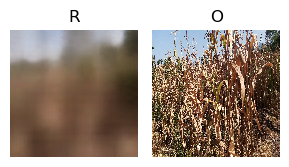

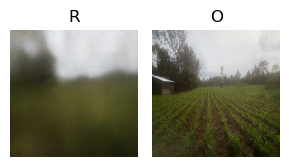

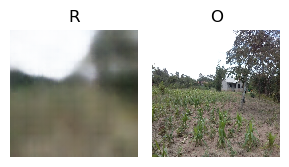

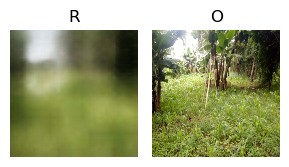

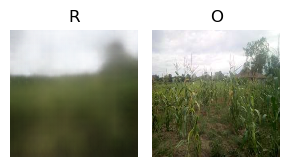

In [22]:
from matplotlib import transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

outputs = {} 

img, _ = next(iter(val_loader))
#img = img.to(device)
custom_autoen_tuned.to('cpu')
out = custom_autoen_tuned(img) 

outputs['img'] = img 
outputs['out'] = out 
  
# Plotting reconstructed images 
# Initializing subplot counter 
counter = 1
val_out = outputs['out'].detach().numpy()
val_img = outputs['img']


# Plotting first 10 images of the batch 
for idx in range(5):
    plt.figure(figsize=(3, 3)) 
    plt.subplot(1, 2, 1) 
    plt.title("R") 
    plt.imshow(np.transpose(val_out[idx], (1, 2, 0))) 
    plt.axis('off') 
    plt.subplot(1, 2, 2) 
    plt.imshow(np.transpose(val_img[idx], (1, 2, 0))) 
    plt.title("O") 
    plt.axis('off')
    plt.tight_layout() 
    plt.show() 

    
# # Plotting original images 
  
# # Plotting first 10 images 
# for idx in range(10): 
     
#     plt.subplot(2, 10, counter) 
#     plt.imshow(val[idx].T) 
#     plt.title("O") 
#     plt.axis('off') 
  
#     # Incrementing subplot counter 
#     counter += 1

### Creating feature extractor

In [42]:
from matplotlib import transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

train_nodes, eval_nodes = get_graph_node_names(Autoencoder())

print(eval_nodes)

feature_extractor_autoen = create_feature_extractor(best_autoen, {'encoder':'feature_output'})
feature_extractor_autoen

['x', 'encoder.0', 'encoder.1', 'encoder.2', 'encoder.3', 'encoder.4', 'encoder.5', 'encoder.6', 'encoder.7', 'encoder.8', 'decoder.0', 'decoder.1', 'decoder.2', 'decoder.3', 'decoder.4', 'decoder.5']


Autoencoder(
  (encoder): Module(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [44]:
feature_extractor_autoen.to(device)

Autoencoder(
  (encoder): Module(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [45]:
summary(feature_extractor_autoen, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 30, 30]          51,264
              ReLU-8           [-1, 64, 30, 30]               0
         MaxPool2d-9           [-1, 64, 15, 15]               0
Total params: 56,352
Trainable params: 56,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.74
Params size (MB): 0.21
Estimated Total Size (MB): 8.14
---------------------------------------------